# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [143]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [144]:
# Load Data 
data = pd.read_csv("assignment2_data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [145]:
#이상치 제거함수: https://bjy2.tistory.com/191 참고.
def dr_outlier(df):
    quartile_1 = df.quantile(0.25)
    quartile_3 = df.quantile(0.75)
    IQR = quartile_3 - quartile_1
    condition = (df < (quartile_1 - 1.5 * IQR)) | (df > (quartile_3 + 1.5 * IQR))
    condition = condition.any(axis=1)
    search_df = df[condition]
    df = df.drop(search_df.index, axis=0)
    return df

data = dr_outlier(data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


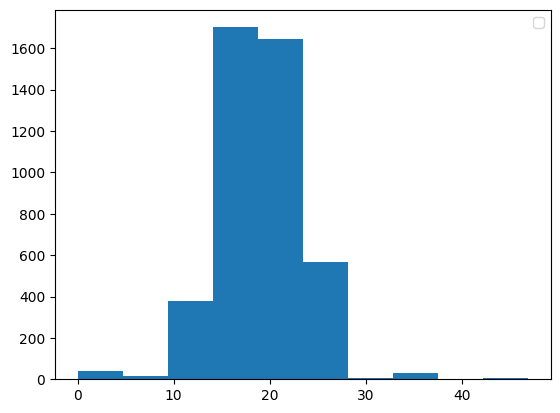

In [146]:
Correct_Mileage= []
for i in data.Mileage:
    if str(i).endswith('km/kg'):
        i = i[:-6]
        i = float(i)*1.40
        Correct_Mileage.append(float(i))
    elif str(i).endswith('kmpl'):
        i = i[:-6]
        Correct_Mileage.append(float(i))
    else:
        Correct_Mileage.append(float(0))

data['Mileage']=Correct_Mileage

#https://www.kaggle.com/code/rushikeshhiray/converting-km-kg-to-kmpl 을 참고하였습니다.

plt.hist(data.Mileage)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


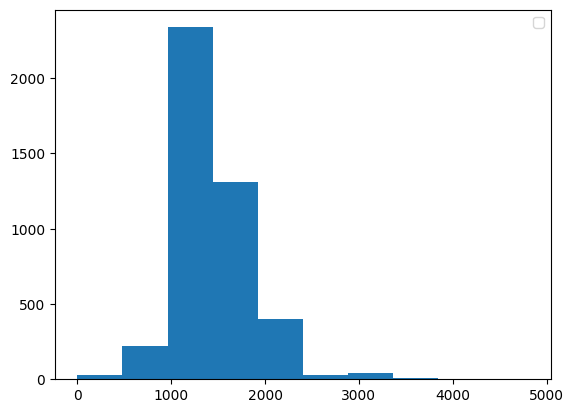

In [147]:
Correct_Engine= []
for i in data.Engine:
    if str(i).endswith('CC'):
        i = i[:-3]
        Correct_Engine.append(float(i))
    else:
        Correct_Engine.append(float(0))

data['Engine']=Correct_Engine
plt.hist(data.Engine)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


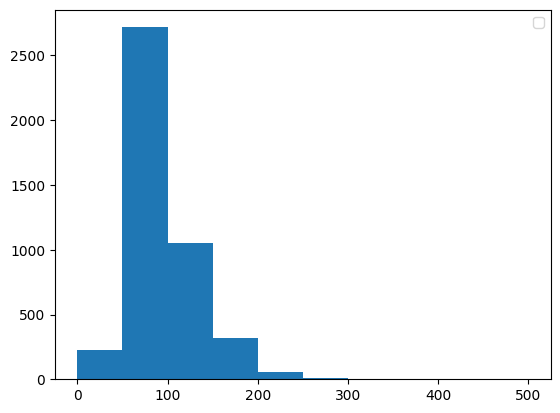

In [148]:
Correct_Power= []
for i in data.Power:
    if str(i).endswith('bhp'):
        i = i[:-4]
        if i == 'null':
            Correct_Power.append(float(0))
        else:
            Correct_Power.append(float(i))
    else:
        Correct_Power.append(float(0))

data['Power']=Correct_Power
plt.hist(data.Power)
plt.legend()
plt.show()

In [149]:
Correct_NewPrice= []
data.New_Price.describe()
#NewPrice는 결측치가 너무 많으므로, 이 열 자체를 분석대상에서 제외한다.

data = data.drop('New_Price', axis = 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


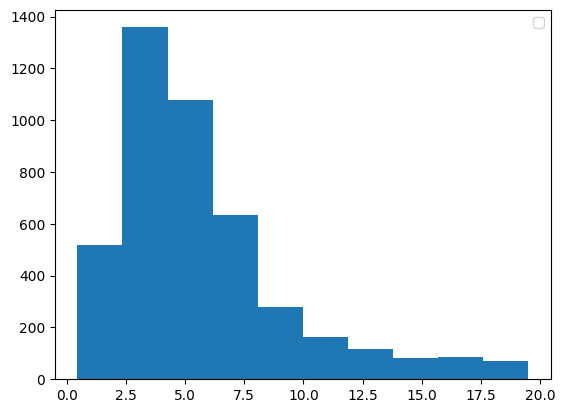

In [150]:
plt.hist(data.Price)
plt.legend()
plt.show()
#가격엔 log를 취할 필요가 있어보인다.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


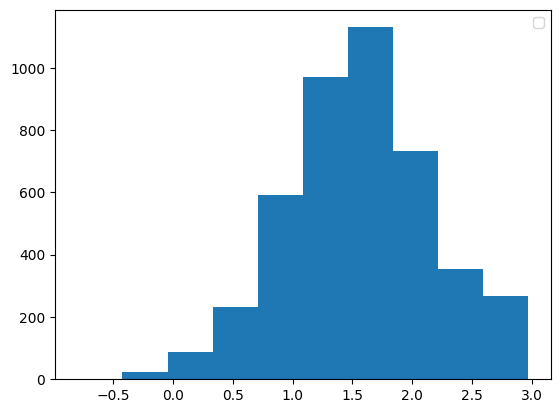

In [151]:
data['log_Price'] = np.log(data['Price'])
plt.hist(data.log_Price)
plt.legend()
plt.show()
#보다 정규성이 확보되는 모습이다.

In [152]:
#결측치는 제거한다.
data = data.replace([np.inf, -np.inf], np.nan) # inf, -inf를 nan으로 대체
data.dropna(inplace=True) # nan 제거
data.describe()

,Unnamed: 0,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,log_Price
count,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.000000,4354.0,4354.000000,4354.000000
mean,3034.972669,2013.312816,53233.125632,19.103962,1402.533532,95.540802,5.0,5.746697,1.564966
std,1725.137868,3.095536,26266.733994,4.501391,380.259712,38.967103,0.0,3.696320,0.610772
min,0.000000,2004.000000,171.000000,0.000000,72.000000,0.000000,5.0,0.450000,-0.798508
25%,1540.750000,2011.000000,33555.000000,17.000000,1197.000000,73.900000,5.0,3.225000,1.170929
50%,3054.500000,2014.000000,52000.000000,19.000000,1248.000000,86.700000,5.0,4.765000,1.561297
75%,4506.750000,2016.000000,70000.000000,22.000000,1499.000000,110.000000,5.0,6.990000,1.944481
max,6018.000000,2019.000000,131000.000000,46.956000,4806.000000,500.000000,5.0,19.500000,2.970414


In [153]:
import statsmodels.api as sm

X = data[['Year',	'Kilometers_Driven',	'Mileage',	'Engine',	'Power',	'Seats']]
y = data['log_Price']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_Price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     2549.
Date:                Tue, 31 Jan 2023   Prob (F-statistic):               0.00
Time:                        23:19:54   Log-Likelihood:                -1050.7
No. Observations:                4354   AIC:                             2113.
Df Residuals:                    4348   BIC:                             2152.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Year                  0.1277      0.00

In [154]:
'''
이상치, 결측치를 제거한 후 히스토그램을 그려가며 각 수치데이터가 정규성을 만족할 수 있도록 하였다.
특히 종속변수는 정규성을 만족하기 위해 Log를 취해주었다.
이후 OLS를 통해 회귀진단을 한 결과는 다음과 같다.

1. 조정된 결정계수가 0.745로, 해당 회귀모델은 비교적 회귀식으로 설명 가능한 부분이 많다.
2. F값은 2549로, 값이 비교적 크게 나왔다. 분산이 큰 편이다.
3. Durbin-Watson 수치는 2.03으로, 2에 매우 가까우므로 해당 모델은 오차항의 자기상관이 없어 독립성을 만족한다.
'''

'\n이상치, 결측치를 제거한 후 히스토그램을 그려가며 각 수치데이터가 정규성을 만족할 수 있도록 하였다.\n특히 종속변수는 정규성을 만족하기 위해 Log를 취해주었다.\n이후 OLS를 통해 회귀진단을 한 결과는 다음과 같다.\n\n1. 조정된 결정계수가 0.745로, 해당 회귀모델은 비교적 회귀식으로 설명 가능한 부분이 많다.\n2. F값은 2549로, 값이 비교적 크게 나왔다. 분산이 큰 편이다.\n3. Durbin-Watson 수치는 2.03으로, 2에 매우 가까우므로 해당 모델은 오차항의 자기상관이 없어 독립성을 만족한다.\n'